# Home Price Model Project Part 4

#### Import Packages

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score


#### Read the data that we cleaned from part 3

In [53]:
traindata=pd.read_parquet('data/new_train.parquet')
testdata=pd.read_parquet('data/new_test.parquet')

In [54]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 1460 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  Overa

# There are 3 non_numeric variables stored as int.
# Let's fix them

In [55]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [56]:
traindata['MSSubClass']=traindata['MSSubClass'].astype('category')
traindata['OverallQual']=traindata['OverallQual'].astype('category')
traindata['OverallCond']=traindata['OverallCond'].astype('category')


#### Check skewness for numeric variables

In [57]:
from scipy.stats import skew

In [58]:
numcol_name=traindata.columns[(traindata.dtypes != 'object')&(traindata.dtypes != 'category')]

In [59]:
skewness = traindata[numcol_name].apply(lambda x: skew(x))

In [60]:
skewness
#>0.75 <-0.75

Id                0.000000
LotFrontage       2.079560
LotArea          12.195142
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.674865
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
FullBath          0.036524
HalfBath          0.675203
BedroomAbvGr      0.211572
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
GarageYrBlt      -3.865524
GarageCars       -0.342197
GarageArea        0.179796
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
MoSold            0.211835
YrSold            0.096170
SalePrice         1.880941
dtype: float64

In [61]:
skewness[skewness>0.75]

LotFrontage       2.079560
LotArea          12.195142
MasVnrArea        2.674865
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtHalfBath      4.099186
KitchenAbvGr      4.483784
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
SalePrice         1.880941
dtype: float64

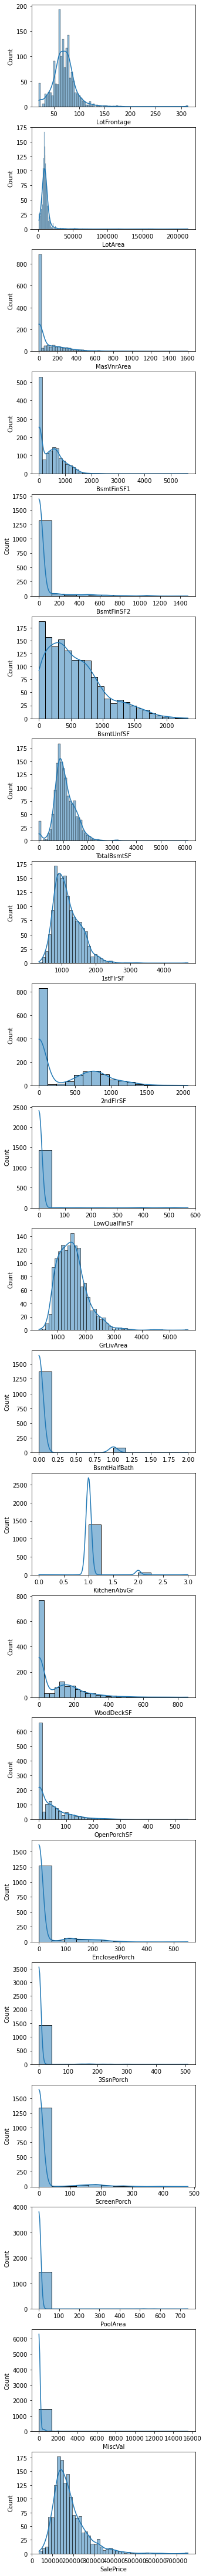

In [62]:
# Plot skewed features
skewed_feats = skewness[skewness>0.75].index
fig,ax = plt.subplots(len(skewed_feats),1, figsize=(5,80))
for i in range(len(skewed_feats)):
    sns.histplot(x=traindata[skewed_feats[i]],kde=True, ax=ax[i])

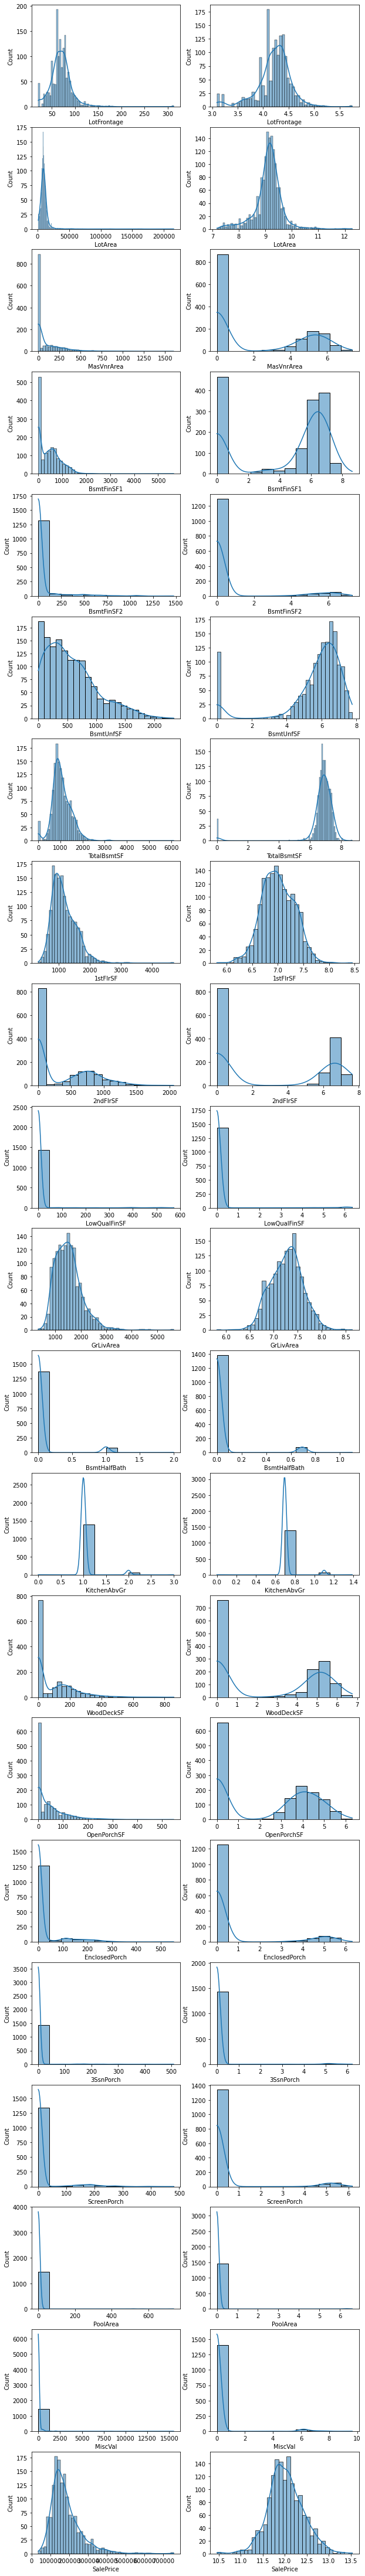

In [63]:
# Let's do a transformation

fig,ax = plt.subplots(len(skewed_feats),2, figsize=(10,80))
for i in range(len(skewed_feats)):
    sns.histplot(x=traindata[skewed_feats[i]],kde=True, ax=ax[i, 0])
    # apply log to skewed features
    traindata[skewed_feats[i]] = np.log1p(traindata[skewed_feats[i]])
    sns.histplot(x=traindata[skewed_feats[i]],kde=True, ax=ax[i, 1])

In [64]:
# Create dummy variables
traindata=pd.get_dummies(traindata)

In [65]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [66]:
# Split training and validation set
X = traindata.drop(columns=['SalePrice'])
y = traindata['SalePrice']

In [67]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=3)

In [68]:
x_train.shape

(1022, 334)

In [69]:
x_valid.shape

(438, 334)

#### Simple Linear Regression

In [70]:
from sklearn.linear_model import LinearRegression

In [71]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 472 to 1273
Columns: 334 entries, Id to SaleCondition_Partial
dtypes: float64(24), int64(10), uint8(300)
memory usage: 578.9 KB


In [72]:
model_lm = LinearRegression()
model_lm.fit(x_train, y_train)

LinearRegression()

In [73]:
y_predicted = model_lm.predict(x_valid)
y_predicted.shape

(438,)

In [74]:
# MAE
AE=np.abs((y_predicted-y_valid))
MAE=np.mean(AE)
print(MAE)

SE=np.square(AE)
MSE=np.mean(SE)
print(MSE)

RMSE=np.sqrt(MSE)
print(RMSE)

0.09219122992789211
0.02418547397257067
0.1555167964323168


In [75]:
len(model_lm.coef_)

334

In [76]:
model_coe=pd.DataFrame(data=model_lm.coef_,index=x_train.columns)
model_coe.sort_values(by=0,ascending=False)

,0
GrLivArea,0.498731
GarageQual_Ex,0.451340
Condition2_PosA,0.441946
SaleType_New,0.289267
RoofStyle_Shed,0.285118
...,...
SaleCondition_Partial,-0.254949
MSZoning_C (all),-0.315525
OverallQual_1,-0.373344
GarageQual_Po,-0.384930


In [77]:
model_coe[0]

Id                      -0.000005
LotFrontage              0.021186
LotArea                  0.077058
YearBuilt                0.002274
YearRemodAdd             0.000576
                           ...   
SaleCondition_AdjLand    0.056964
SaleCondition_Alloca     0.075726
SaleCondition_Family    -0.011313
SaleCondition_Normal     0.101237
SaleCondition_Partial   -0.254949
Name: 0, Length: 334, dtype: float64

In [ ]:
# How can we improve this linear model?
#feature engineering

#### Lasso Regression

In [78]:
from sklearn.linear_model import Lasso

In [79]:
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(x_train,y_train)

Lasso(alpha=0.1)

In [80]:
y_lasso_predicted=model_lasso.predict(x_valid)
y_lasso_predicted.shape

(438,)

In [82]:
AE=np.abs((y_lasso_predicted-y_valid))
MAE=np.mean(AE)
print(MAE)

SE=np.square(AE)
MSE=np.mean(SE)
print(MSE)

RMSE=np.sqrt(MSE)
print(RMSE)

0.1616211762552008
0.045272552857657654
0.2127734778059936


In [83]:
model_coe=pd.DataFrame(data=model_lasso.coef_,index=x_train.columns)
model_coe.sort_values(by=0,ascending=False).head(10)


,0
TotRmsAbvGrd,0.047223
BsmtFinSF1,0.010152
YearRemodAdd,0.004699
YearBuilt,0.002936
2ndFlrSF,0.002080
GarageArea,0.000701
OpenPorchSF,0.000464
GarageYrBlt,0.000029
BsmtQual_Fa,-0.000000
BsmtQual_Gd,0.000000


In [84]:
model2_lasso = Lasso(alpha=0.5)
model2_lasso.fit(x_train,y_train)
y_lasso_predicted=model2_lasso.predict(x_valid)
y_lasso_predicted.shape
model2_coe=pd.DataFrame(data=model2_lasso.coef_,index=x_train.columns)
model2_coe.sort_values(by=0,ascending=False).head(10)

,0
YearRemodAdd,0.004272
YearBuilt,0.002475
GarageArea,0.000905
GarageYrBlt,0.000016
BsmtCond_Gd,0.000000
BsmtExposure_None,-0.000000
BsmtExposure_No,-0.000000
BsmtExposure_Mn,0.000000
BsmtExposure_Gd,0.000000
BsmtExposure_Av,-0.000000


#### Ridge Regression

In [85]:
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha=0.1)
model_ridge.fit(x_train,y_train)

y_ridge_predicted=model_ridge.predict(x_valid)
y_ridge_predicted.shape

(438,)

In [86]:
mean_absolute_error(y_valid,y_ridge_predicted)

0.08960944285518221

In [87]:
AE=np.abs((y_ridge_predicted-y_valid))
MAE=np.mean(AE)
print(MAE)

SE=np.square(AE)
MSE=np.mean(SE)
print(MSE)

RMSE=np.sqrt(MSE)
print(RMSE)

0.08960944285518231
0.02283156268909415
0.1511011670672803


In [88]:
model_coe=pd.DataFrame(data=model_ridge.coef_,index=x_train.columns)
abs_model_coe=np.abs(model_coe)
abs_model_coe.sort_values(by=0,ascending=False).head(20)


,0
Condition2_PosN,0.518851
GrLivArea,0.474069
GarageQual_Ex,0.340212
Condition2_PosA,0.334708
OverallQual_1,0.312788
MSZoning_C (all),0.305031
SaleType_New,0.257889
GarageQual_Po,0.243962
SaleCondition_Partial,0.229398
RoofStyle_Shed,0.204238


In [89]:
X = traindata.drop(columns=['SalePrice'])
y = traindata['SalePrice']
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=3)
x_train.shape

(1022, 334)

In [90]:
model_ridge = Ridge(alpha=0.1)
model_ridge.fit(x_train,y_train)

y_ridge_predicted=model_ridge.predict(x_valid)
y_ridge_predicted.shape


(438,)

In [91]:
AE=np.abs((y_ridge_predicted-y_valid))
MAE=np.mean(AE)
print(MAE)

SE=np.square(AE)
MSE=np.mean(SE)
print(MSE)

RMSE=np.sqrt(MSE)
print(RMSE)

0.08960944285518231
0.02283156268909415
0.1511011670672803


In [96]:
#reduce-MSE-Adjust Vriable

train_data_try1=traindata.drop(columns=['BsmtFullBath','GarageYrBlt','1stFlrSF'])
dummy_train_data_try1=pd.get_dummies(train_data_try1)



X = dummy_train_data_try1.drop(columns=['SalePrice'])
y = dummy_train_data_try1['SalePrice']
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=3)


from sklearn.linear_model import LinearRegression

model_lm = LinearRegression()
model_lm.fit(x_train, y_train)
y_predicted = model_lm.predict(x_valid)
y_predicted.shape


AE=np.abs((y_predicted-y_valid))
MAE=np.mean(AE)
print(MAE)

SE=np.square(AE)
MSE=np.mean(SE)
print(MSE)

RMSE=np.sqrt(MSE)
print(RMSE)

0.09182405084964396
0.02395863400246229
0.15478576808758063
